In [1]:
from himalaya.kernel_ridge import KernelRidgeCV
import os
import json
import numpy as np
#from himalaya.utils import load_hdf5_array
from config.dir import DATA_DIR, EM_DATA_DIR ,REPO_DIR

In [49]:
subject = "sub-UTS01"
dir ='results/eng1000'
file_name = os.path.join(REPO_DIR, dir,subject,'features.json')
with open(file_name, "r") as f:
	X_train = json.load(f)

X_train = np.array(X_train, dtype=float)
X_test = np.array(X_train, dtype=float)
X_train = np.vstack((X_train, X_train))
print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_train, n_features) =", X_test.shape)

(n_samples_train, n_features) = (3648, 985)
(n_samples_train, n_features) = (1824, 985)


In [42]:
subject = "sub-UTS01"
subject2 = "sub-UTS02"
subject_test = "sub-UTS03"
dir ='results/eng1000/'
with open(os.path.join(REPO_DIR, dir,subject,'fmri.json'), "r") as f:
	Y_train = json.load(f)
with open(os.path.join(REPO_DIR, dir,subject2,'fmri.json'), "r") as f:
	Y_train2 = json.load(f)
with open(os.path.join(REPO_DIR, dir,subject_test,'fmri.json'), "r") as f:
	Y_test = json.load(f)
Y_train = np.array(Y_train, dtype=float)
Y_train =np.pad(Y_train, [(0, 0), (0, 94251-81126)], mode='constant')
Y_train2 = np.array(Y_train2, dtype=float)
Y_test = np.array(Y_test, dtype=float)
print("(n_samples_train, n_voxels) =", Y_train.shape)
print("(n_samples_train2, n_voxels) =", Y_train2.shape)
print("( n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (1824, 94251)
(n_samples_train2, n_voxels) = (1824, 94251)
( n_samples_test, n_voxels) = (1824, 94251)


In [43]:
Y_train_= np.vstack((Y_train, Y_train2))
print("(n_samples_train, n_voxels) =", Y_train_.shape)

(n_samples_train, n_voxels) = (3648, 94251)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=False)

In [5]:
from voxelwise_tutorials.delayer import Delayer
from himalaya.kernel_ridge import KernelRidgeCV
delayer = Delayer(delays=[1, 2, 3, 4])

In [51]:
X_train_= X_train.astype("float32")
alphas = np.logspace(1, 20, 20)

In [45]:
kernel_ridge_cv = KernelRidgeCV(
    alphas=alphas,
    solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                       n_targets_batch_refit=100))

In [46]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    scaler,
    delayer,
    kernel_ridge_cv,
)

In [47]:
_ = pipeline.fit(X_train, Y_train_)

In [17]:
scores = pipeline.score(X_train, Y_train)
print("(n_voxels,) =", scores.shape)

(n_voxels,) = (81126,)


In [53]:
scores = pipeline.score(X_test, Y_test)
print("(n_voxels,) =", scores.shape)

(n_voxels,) = (94251,)


In [56]:
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")

/Users/genevievelam/Documents/GitHub/stories_fmri/.venv/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [57]:
scores = backend.to_numpy(scores)

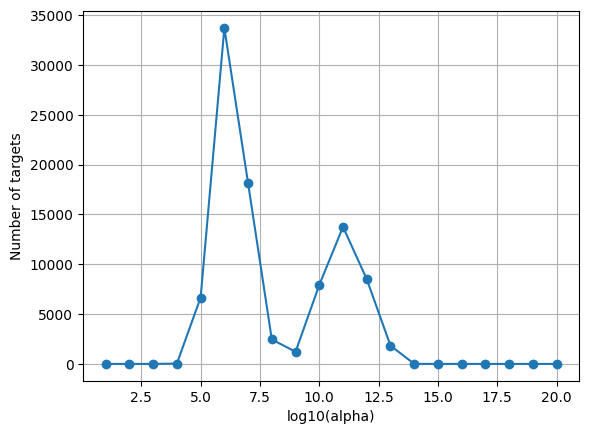

In [58]:
from himalaya.viz import plot_alphas_diagnostic
best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
plt.show()

In [59]:
primal_coef = pipeline[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("(n_delays * n_features, n_voxels) =", primal_coef.shape)

(n_delays * n_features, n_voxels) = (3940, 94251)


In [60]:
primal_coef /= np.linalg.norm(primal_coef, axis=0)[None]
primal_coef *= np.sqrt(np.maximum(0, scores))[None]

In [62]:
# split the ridge coefficients per delays
delayer = pipeline.named_steps['delayer']
primal_coef_per_delay = delayer.reshape_by_delays(primal_coef, axis=0)
print("(n_delays, n_features, n_voxels) =", primal_coef_per_delay.shape)
del primal_coef

# average over delays
average_coef = np.mean(primal_coef_per_delay, axis=0)
print("(n_features, n_voxels) =", average_coef.shape)
del primal_coef_per_delay

(n_delays, n_features, n_voxels) = (4, 985, 94251)
(n_features, n_voxels) = (985, 94251)


In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(average_coef.T)
components = pca.components_
print("(n_components, n_features) =", components.shape)

(n_components, n_features) = (4, 985)


In [64]:
 print("PCA explained variance =", pca.explained_variance_ratio_)

PCA explained variance = [0.18034536 0.15147272 0.07549126 0.06679408]


In [65]:
from voxelwise_tutorials.wordnet import load_wordnet
from voxelwise_tutorials.wordnet import correct_coefficients
_, wordnet_categories = load_wordnet(directory=directory)
components = correct_coefficients(components.T, wordnet_categories).T
components -= components.mean(axis=1)[:, None]
components /= components.std(axis=1)[:, None]

NameError: name 'directory' is not defined

In [21]:
import cortex

surface = "fsaverage"

if not hasattr(cortex.db, surface):
    cortex.utils.download_subject(subject_id=surface,
                                  pycortex_store=cortex.db.filestore)
    cortex.db.reload_subjects()  # force filestore reload
    assert hasattr(cortex.db, surface)

Done downloading to /var/folders/qn/4j79nql573v32rqq5g7h42940000gn/T/tmpy4c4kld_/fsaverage.tar.gz
Extracting subject fsaverage to /opt/anaconda3/envs/py39/share/pycortex/db


In [ ]:
from voxelwise_tutorials.io import load_hdf5_sparse_array
voxel_to_fsaverage = load_hdf5_sparse_array(mapper,
                                            key='voxel_to_fsaverage')
ev_projected = voxel_to_fsaverage @ ev
print("(n_vertices,) =", ev_projected.shape)

In [ ]:
import matplotlib.pyplot as plt
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

#mapper_file = os.path.join("/Users/genevievelam/Documents/GitHub/ds003020/sub-UTS01/ses-1/anat/sub-UTS01_ses-1_T1w.nii.gz", f"{subject}_mappers.hdf")
ax = plot_flatmap_from_mapper(scores, "/Users/genevievelam/Documents/GitHub/ds003020/derivative/pycortex-db/UTS01/cache/flatmask_1024.npz", vmin=0, vmax=0.4)
plt.show()